In [46]:
# === ESTRATÉGIA DE PAIR TRADING GENERALIZADA ===
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
from scipy.stats import zscore


In [47]:
# ===================================================================
#                          CONFIGURAÇÕES
# Para testar um novo par, altere apenas as variáveis nesta seção.
# ===================================================================

# --- ATIVOS ---
# Ativo 1 (será vendido quando o spread estiver alto)
TICKER_A = 'BBD' 
# Ativo 2 (será comprado quando o spread estiver alto)
TICKER_B = 'SAN' 

# --- PERÍODO ---
START_DATE = '2019-07-01'
END_DATE = '2024-07-01'

# --- PARÂMETROS DA ESTRATÉGIA ---
# Z-Score para entrar na operação
ENTRY_Z = 1.0
# Z-Score para sair da operação (quando retorna próximo de zero)
EXIT_Z = 0.1
# ===================================================================



In [48]:
# 1. COLETA DE DADOS
# A lista de tickers é criada a partir das configurações acima.
tickers = [TICKER_A, TICKER_B]
df = yf.download(tickers, start=START_DATE, end=END_DATE)['Close'].dropna()


C:\Users\Usuário\AppData\Local\Temp\ipykernel_14232\2491477326.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start=START_DATE, end=END_DATE)['Close'].dropna()
[*********************100%***********************]  2 of 2 completed


In [49]:
# 2. TESTE DE COINTEGRAÇÃO
# O teste agora usa as variáveis dos tickers, tornando-o flexível.
score, pvalue, _ = coint(df[TICKER_A], df[TICKER_B])
print(f"--- Análise de Cointegração para {TICKER_A} e {TICKER_B} ---")
print(f"P-valor do teste Engle-Granger: {pvalue:.4f}")

if pvalue < 0.05:
    print("Resultado: Os ativos são considerados cointegrados (p < 0.05). A estratégia é aplicável.")
else:
    print("Resultado: Os ativos NÃO são considerados cointegrados (p >= 0.05). A estratégia pode não ser adequada.")


--- Análise de Cointegração para BBD e SAN ---
P-valor do teste Engle-Granger: 0.2783
Resultado: Os ativos NÃO são considerados cointegrados (p >= 0.05). A estratégia pode não ser adequada.


In [50]:
# 3. CÁLCULO DO SPREAD E Z-SCORE
# O cálculo do spread também se torna genérico.
spread = df[TICKER_A] - df[TICKER_B]
zscore_spread = zscore(spread)


In [51]:
# 4. ESTRATÉGIA DE NEGOCIAÇÃO
# A lógica do loop já era genérica. Apenas a saída precisa ser adaptada.
signals = pd.DataFrame(index=df.index)
signals['Z-Score'] = zscore_spread
signals['Position'] = 0  # Posição no SPREAD: 1=long, -1=short, 0=flat

position = 0
for i in range(len(signals)):
    z = signals['Z-Score'].iloc[i]
    
    # Condição de entrada: Short Spread (Vender A, Comprar B)
    if position == 0 and z > ENTRY_Z:
        position = -1
    # Condição de entrada: Long Spread (Comprar A, Vender B)
    elif position == 0 and z < -ENTRY_Z:
        position = 1
    # Condição de saída: Se posicionado e o Z-score reverteu
    elif position != 0 and abs(z) < EXIT_Z:
        position = 0
    
    signals.loc[signals.index[i], 'Position'] = position

# Mapear a posição do spread para as posições dos ativos individuais de forma dinâmica
pos_col_A = f'Position_{TICKER_A}'
pos_col_B = f'Position_{TICKER_B}'
signals[pos_col_A] = -signals['Position'] # Vende A (-1) quando está long no spread (1)
signals[pos_col_B] = signals['Position']  # Compra B (1) quando está long no spread (1)


In [52]:
# 5. CÁLCULO DOS RETORNOS DA ESTRATÉGIA
# Usa a lista de colunas de posição criada dinamicamente.
position_cols = [pos_col_A, pos_col_B]
returns = (signals[position_cols].shift(1) * df.pct_change()).sum(axis=1)
cumulative_returns = (1 + returns).cumprod()


In [53]:
# 6. MÉTRICAS DE DESEMPENHO
if np.std(returns) == 0:
    sharpe = 0.0
else:
    sharpe = np.mean(returns) / np.std(returns) * np.sqrt(252)

running_max = cumulative_returns.cummax()
drawdown = (cumulative_returns - running_max) / running_max
max_drawdown = drawdown.min()

print("\n--- Métricas de Desempenho ---")
print(f"Sharpe Ratio Anualizado: {sharpe:.2f}")
print(f"Drawdown Máximo: {max_drawdown:.2%}")



--- Métricas de Desempenho ---
Sharpe Ratio Anualizado: 0.00
Drawdown Máximo: 0.00%


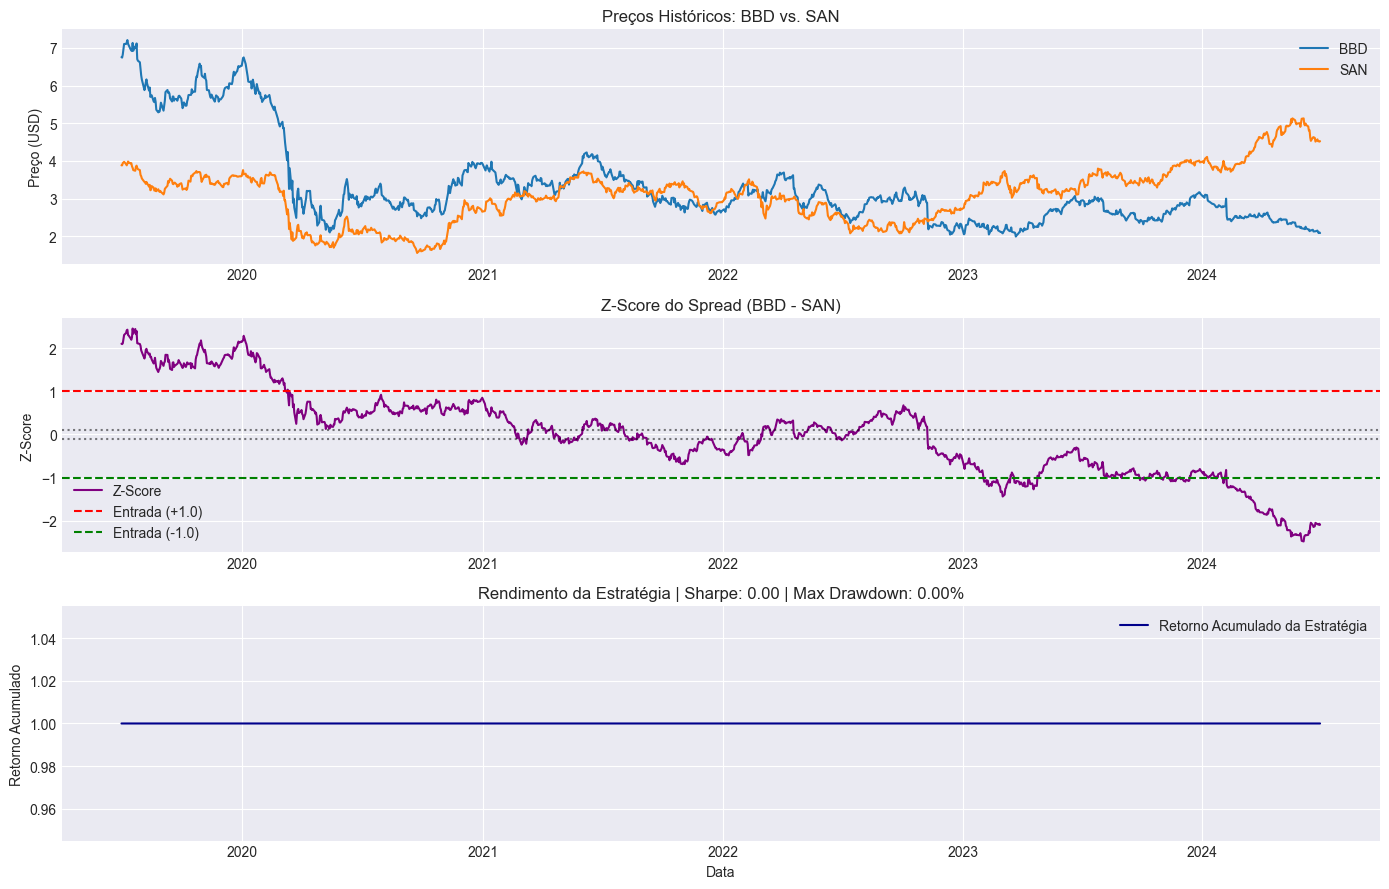

In [55]:
# 7. GRÁFICOS
# Os títulos e legendas dos gráficos agora são gerados dinamicamente.
plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(14, 9))

# Gráfico 1: Preço dos ativos
plt.subplot(3, 1, 1)
plt.plot(df[TICKER_A], label=TICKER_A)
plt.plot(df[TICKER_B], label=TICKER_B)
plt.title(f'Preços Históricos: {TICKER_A} vs. {TICKER_B}')
plt.legend()
plt.ylabel('Preço (USD)')

# Gráfico 2: Z-score do spread
plt.subplot(3, 1, 2)
plt.plot(signals['Z-Score'], color='purple', label='Z-Score')
plt.axhline(ENTRY_Z, color='red', linestyle='--', label=f'Entrada (+{ENTRY_Z})')
plt.axhline(-ENTRY_Z, color='green', linestyle='--', label=f'Entrada (-{ENTRY_Z})')
plt.axhline(EXIT_Z, color='black', linestyle=':', alpha=0.5)
plt.axhline(-EXIT_Z, color='black', linestyle=':', alpha=0.5)
plt.title(f'Z-Score do Spread ({TICKER_A} - {TICKER_B})')
plt.legend()
plt.ylabel('Z-Score')

# Gráfico 3: Curva de capital
plt.subplot(3, 1, 3)
plt.plot(cumulative_returns, label='Retorno Acumulado da Estratégia', color='darkblue')
plt.title(f'Rendimento da Estratégia | Sharpe: {sharpe:.2f} | Max Drawdown: {max_drawdown:.2%}')
plt.legend()
plt.ylabel('Retorno Acumulado')
plt.xlabel('Data')

plt.tight_layout()
plt.show()